# The Physical Layer as an Autoencoder


An autoencoder is a type of artificial neural network used to find a useful representation of some data $\mathbf{s}$ at an intermediate layer $\mathbf{x}$ through learning to reproduce the input at the output.

<img src="https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder_0.png?raw=true" alt="Drawing" style="width: 400px;"/>


# Initialisation

**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

In [1]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [2]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.1.0
Number of GPUs available : 4
Only GPU number 0 used


In [3]:
import numpy as np
import matplotlib.pyplot as plt  


# --> Import Model, Layer, Dense, Softmax

In [4]:
SEED = 1

# Modulation

Remember modulation : the goal is to find a good set of symbols to send over a channel.

If we want to send 3 bits, we need to have **8 symbols** :  
![Modulation](https://github.com/mgoutay/ml_course/blob/master/Images/AWGN.png?raw=true)

The constellation (here 8-PSK) needs to be robust to the channel (here AWGN channel).

What we want is to find a better constellation !

# Communicating messages

**An autoencoder-based communication systems aims to implement the transmitter, channel, and receiver as a single NN which reconstructs its input at its output**

The goal is to learn a modulation wich will be robust with respect to the perturbations introduced by the channel.

The channel is implemented as a "Noise Layer" without any learnable parameters, wich must be differentiable in order to perform SGD on the transmitter's parameters.

Examples:

- AWGN channel : $y = x + n$

- ...

![autoencoder](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder.png?raw=true)

Let's transmit messages.

The first hyper-parameter to set is the total number of symbols (or message) $M$.
In our simple problem, the number of channel uses $N_c$ is set to 1.

It can be seen that $M$ can also be seen as the modulation order. Indeed, sending one out of $M$ symbols (message) is equivalent to sending $\log_2(M)$ bits.

We will implement the fowllowing network:


<img src="https://github.com/mgoutay/ml_course/blob/master/Images/autoencoder.png?raw=true" alt="Drawing" style="width: 700px;"/>

1. Each message $m$ is first converted to its one_hot representation. If we have the 3rd out of 8 message, the one_hot representation will be $[0, 0, 1, 0, 0, 0, 0, 0]$
2. That one_hot vector is then given to the first dense layer.
3. The last dense layer of the tranmsitter will output $2$ real numbers per symbol. 
4. They will be normalized to have an average energy of $1$ by the normalization layer. 
5. Then the $\mathbb{R}2\mathbb{C}$ layer will convert those $2$ numbers onto 1 complex number, that will be sent over the channel. Those are the transmitted symbols $x$.
6. The channel will add some random gaussian noise (AWGN channel)
7. The $\mathbb{C}2\mathbb{R}$ layer converts the complex number into $2$ real numbers, that are given to the first dense layer. This is mandatory since Tensorflow does not have complex dense layers. The last dense layer has $M$ output (the number of different symbols).
8. The output of the last dense layer is given to the softmax layer. For a given received $y$, it outputs probabilities $\mathbf{p}_m = [p(m=0|y), p(m=1|y), ..., p(m=M|y)]$ that each symbols have been sent. Those probabilities are useful during training.


* Indeed, this is a typical classification task. We want to predict in which "class" (which symbol) the received signal $y$ belongs to. The usual loss for classification task is the categorical cross-entropy, which "compare" the true class ($m$) with the predicted probabilities $p_m$.


9. We take the symbol with the highest probability to have been sent with the $\text{argmax}$ layer. This is $\hat{m}$.



## Define the layers

In [5]:
class Normalization(Layer):

    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, symbols):        
        # Normalize power per symbol to 1
        en_moy = tf.sqrt(2 * tf.reduce_mean(tf.square(symbols)))
        symbols_norm = tf.divide(symbols, en_moy)
        
        return symbols_norm

In [6]:
class R2C(Layer):

    def __init__(self, **kwargs):
        super(R2C, self).__init__(**kwargs)

    def call(self, x):
        # Converts 2Nc real numbers into Nc complex numbers
        x_cplx = tf.complex(x[:, :1], x[:, 1:])
            
        return x_cplx

In [7]:
class C2R(Layer):

    def __init__(self, **kwargs):
        super(C2R, self).__init__(**kwargs)

    def call(self, y):
        #converts Nc complex numbers into 2Nc real numbers
        y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
            
        return y_real

In [8]:
class OneHot(Layer):

    def __init__(self, M, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.M = M

    def call(self, msg):
        
        one_hot_msg = tf.one_hot(msg, depth = M)
        
        return one_hot_msg

In [9]:
class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)
            
    def call(self, x, snr):
        # Adds random Gaussian noise to the input
        noise_stddev = tf.sqrt( 2 / tf.pow(10., snr/10.0))
        noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        noise_cplx = tf.complex(noise_r, noise_i, name="noise")

        y = x + noise_cplx

        return y

## Generate messages

In [10]:
def generate_ds_msg(epoch_len, batch_size, M):
    
    #Generate a dataset of 'epoch_len' batches of messages.
    #Each batch have a size 'batch_size' and consists of messages (symbols) betwen 0 and M-1
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    features_ds = tf.data.Dataset.from_tensor_slices(rand_msg)
    
    #The labels are the same as the features : this is an autoencoder, we want to predict the same message that has been sent.
    labels_ds = features_ds
    
    return (features_ds, labels_ds)

## Define the model

In [11]:
class Autoencoder(Model):

    def __init__(self, M, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        #Set the class' attributes
        self.M = M

        # --> Initialise the transmitter layers
                
        self.ch = Channel()
        
        # --> Initialise the receiver layers

    
    def call(self, inputs, snr):
        
        # Transmitter
        # --> Forward pass in the transmitter
        # Remember : the last Dense layer should have 2 neurons (real and imaginary part of the symbol)
    
        #Channel
        self.y = self.ch(self.x, snr)
        
        #Receiver
        # --> Forward pass in the receiver
        # Remember : the last Dense layer should have M neurons (one for each "categor")
    
        return # --> return the result

## What about the loss function?

The loss function is the **sparse** (there is only one good class) **categorical cross-entropy**:

In [12]:
loss_func = # --> Define the loss function

## Instantiate the autoencoder

In [13]:
# Number of messages
M = 8

In [14]:
#Set the seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Create the autoencoder
autoencoder = Autoencoder(M)

# See constellation before training

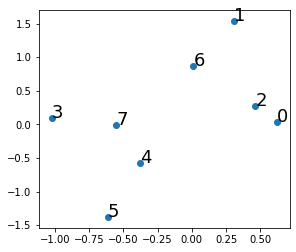

In [15]:
snr_eval = 10

# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(4.5, 4))
plt.scatter(np.real(x_np[:, 0]), np.imag(x_np[:, 0]))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i, 0]), np.imag(x_np[i, 0]), str(msg_np[i]), fontsize=18)

# Train

In [16]:
batch_size = 10000
epoch_size = 100
nb_epoch = 25
snr_training = 15

print('Symbol Error Rate after each epoch:')

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

for epoch in range(nb_epoch):
    
    # Create a random dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_msg(epoch_size, batch_size, M))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas =  # --> Do a forward pass, giving the features and the snr_training

            # Loss value for this batch.
            loss_value =  # --> Compute the loss

        # Get gradients of loss wrt the weights.
        gradients =  # --> Compute gradients

        # Update the weights of our linear layer.
        # --> Update the weights
    
    #Take the argmax of the probability distribution as the estimated message
    m_hat = tf.argmax(probas, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(labels-m_hat), 0, 1))/(batch_size)
    print(ser.numpy(), end=', ')
print('Done')

Symbol Error Rate after each epoch:
0.2302, 0.0468, 0.014, 0.01, 0.0111, 0.0109, 0.0107, 0.011, 0.0105, 0.009, 0.0102, 0.0094, 0.0102, 0.0091, 0.0107, 0.0111, 0.0097, 0.0098, 0.0112, 0.0094, 0.009, 0.0113, 0.0097, 0.0106, 0.009, Done


## Evaluate the model

In [21]:
snr_range = np.arange(-5, 21)
results=[]
bs_eval = 100000

for snr_eval in snr_range:
    
    batch_msg = tf.random.uniform(shape=[bs_eval], minval=0, maxval=M, dtype=tf.int32)
    
    p_m = autoencoder(batch_msg, snr_eval)
    m_hat = tf.argmax(p_m, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(batch_msg-m_hat), 0, 1))/(bs_eval)
    print(snr_eval, end=', ')
    results.append(ser.numpy())

-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

In [22]:
PSK8 = np.array([0.77506, 0.765, 0.74813, 0.7275, 0.70289, 0.68373, 0.65119, 0.62056, 0.58119, 0.54035, 0.49605, 0.44836, 0.39359, 0.34086, 0.28307, 0.22817, 0.17711, 0.12972, 0.09176, 0.05412, 0.03235, 0.01594, 0.0068, 0.00256, 0.00071, 0.00015])

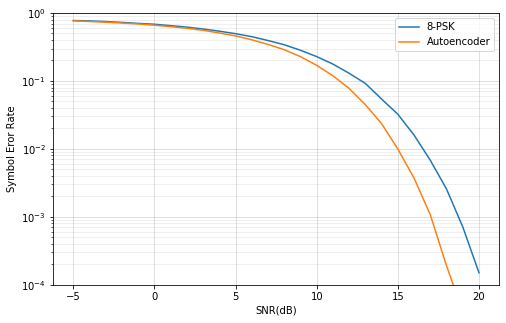

In [23]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, PSK8, label='8-PSK')
plt.semilogy(snr_range, results, label='Autoencoder')
plt.legend()
plt.xlabel('SNR(dB)')
plt.ylabel('Symbol Eror Rate');
plt.ylim(1e-4, 1)
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

## See learned constellation

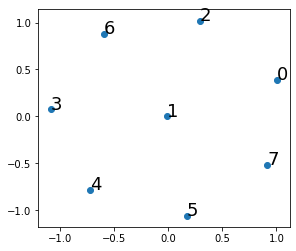

In [24]:
snr_eval = 10

# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(4.5, 4))
plt.scatter(np.real(x_np[:, 0]), np.imag(x_np[:, 0]))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i, 0]), np.imag(x_np[i, 0]), str(msg_np[i]), fontsize=18)